<a href="https://colab.research.google.com/github/tc3oliver/StratLabFreq/blob/dev/MACD_Divergence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 下載及 import

In [31]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/StratLabFreq')
os.listdir()

['data', 'TaipeiSansTCBeta-Regular.ttf', 'MACD_Divergence_Analysis.ipynb']

In [32]:
!pip install mplfinance

In [33]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import statistics

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib
import talib.abstract as ta

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4291    0  4291    0     0  15000      0 --:--:-- --:--:-- --:--:-- 15003
100  517k  100  517k    0     0   816k      0 --:--:-- --:--:-- --:--:--  816k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4251    0  4251    0     0  10756      0 --:--:-- --:--:-- --:--:-- 10734
100  392k  100  392k    0     0   496k      0 --:--:-- --:--:-- --:--:--  496k


## 載入資料


In [34]:
dataframe = pd.read_json('./data/BTC_USDT-5m.json')
dataframe.columns=['date', 'open' , 'high', 'low', 'close', 'volume' ]
dataframe['date']=(pd.to_datetime(dataframe['date'],unit='ms'))

In [35]:
macd = ta.MACD(dataframe, fastperiod=13, slowperiod=34)
dataframe['macdhist'] = macd['macdhist']

## 隨機選取 count K棒

In [36]:
import random

count = 40

def get_random_count_values_dataframe(df):
    if len(df) < count:
        raise ValueError("DataFrame 中的資料數量不足 40 個")

    start_index = random.randint(0, len(df) - count)

    selected_values = df.iloc[start_index : start_index + count]

    selected_df = pd.DataFrame(selected_values)

    return selected_df

In [37]:
df = get_random_count_values_dataframe(dataframe)
df.head()

,date,open,high,low,close,volume,macdhist
608076,2023-06-04 11:55:00,27184.83,27198.55,27184.82,27198.55,29.60512,-6.638618
608077,2023-06-04 12:00:00,27198.54,27198.55,27177.10,27177.10,100.33065,-7.766362
608078,2023-06-04 12:05:00,27177.11,27193.04,27177.10,27193.04,50.34164,-7.132468
608079,2023-06-04 12:10:00,27193.03,27194.40,27193.03,27194.39,18.07231,-6.376895
608080,2023-06-04 12:15:00,27194.39,27194.82,27176.68,27176.68,39.60966,-6.873135


## 尋找 macd 柱狀體波峰

In [38]:
# 尋找三個峰值且這些波峰連續升高
def find_peak_sequence(data):
        peaks_index = []
        wave = []

        for i in range(len(data)):
            if i == len(data) - 1:
                break
            d = abs(data[i])
            if len(wave) == 0 or d > wave[-1]:
                wave.append(d)
            else:
                if len(wave) > 1:
                    peaks_index.append(i-1)
                wave = [d]

        if len(wave) > 0:
            peaks_index.append(i)

        highlighted_points = [(index, data[index]) for index in peaks_index]

        temp = highlighted_points[-1]


        if len(highlighted_points) < 3:
            return False, []

        highlighted_points = highlighted_points[:-1]

        highlighted_points = sorted(
            highlighted_points, key=lambda x: abs(x[1]), reverse=True)[:2]
        highlighted_points = sorted(
            highlighted_points, key=lambda x: x[0], reverse=False)
        highlighted_points.append(temp)

        if len(highlighted_points) >= 3:
          # 波峰的差異
          percentage_difference = abs(abs(highlighted_points[-1][1]) - abs(highlighted_points[-3][1])) / (abs(highlighted_points[-3][1])) * 100

          # 波峰的步數
          step = abs(highlighted_points[-3][0] - highlighted_points[-1][0])

          print(percentage_difference, step)

          if percentage_difference < 50:
            return False, []

          if step < count * 0.5:
            return False, []

          if abs(highlighted_points[-3][1]) > abs(highlighted_points[-2][1]) > abs(highlighted_points[-1][1]):
            return True, highlighted_points

        return False, []



## 多單

In [39]:
# 判斷低點持續降低
min_open_close = pd.Series.min(dataframe[['open', 'close']], axis=1)
dataframe['is_low_decreasing'] = min_open_close.rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < min(x[:-1])), raw=True)

# 多單條件檢查 零軸以下的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_logn_wrapper(data):
  if data[-1] > 0:
    return False, []
  count = sum(1 for value in data if value < 0)
  if count < (len(data) / 2):
      return False, []
  return find_peak_sequence(data)

18.24196656502109 38
72.88098103357027 30
62.41665479910914 20
82.49292087843767 24
96.53913283476821 34
95.45240269921709 31
96.43497492465866 37
93.66574836901057 37
36.794542480580645 18
95.06315792811165 26
95.22300946172444 20
64.58572636930187 35
66.97908004254215 13
26.319077672367747 33
83.7540839207246 13
39.03801025532911 22
66.13741591505963 27
[-11.81694179559124, -19.666042028912322, -8.493901827565146, -4.508028959409927, -11.770523991434423, -18.06345910688289, -19.769512750099253, -38.45347488156405, -58.013664487068326, -86.37794748210233, -116.37639415453026, -116.81542064508898, -117.74803237457232, -96.87490516475748, -79.66029791109332, -59.95582176632837, -47.2112300155913, -35.48234318430036, -10.201099116725345, 6.385908792197711, 24.738849525417322, 31.021463203515395, 30.770031407034907, 29.91347689228394, 33.94422552174865, 42.75940228554356, 35.766149298971015, 30.7955087641422, 8.444185187396982, 4.197688922621353, -2.711905180691474, -8.807590714274738, 11

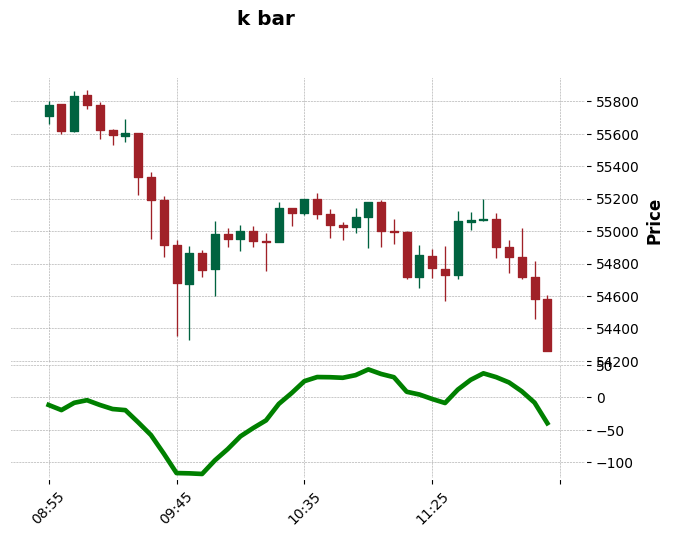

In [40]:
while True:

  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_logn_wrapper(data)


  if isfind:

    if df['is_low_decreasing'].values.tolist()[-1]:
      print(data)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

## 空單

In [41]:
# dataframe['is_high_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)
# 判斷高點持續提高
max_open_close = pd.Series.max(dataframe[['open', 'close']], axis=1)
dataframe['is_high_increase'] = max_open_close.rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)

# 空單條件檢查 零軸以上的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_short_wrapper(data):
            if data[-1] < 0:
                return False, []
            if abs(statistics.mean(x for x in data[-3:-1])) > abs(data[-1]):
                return False, []
            count = sum(1 for value in data if value > 0)
            if count < (len(data) / 2):
                return False, []
            return find_peak_sequence([n for n in data if n > 0])

66.76624193330693 16
74.67518370876115 15
46.192607289741986 14
877.2243854892178 11
13.367140800486013 10
46.67660601864061 24
82.25147513124165 18
91.77704534455938 14
97.0523055972248 20
61.30209596252653 23
94.95230246952258 19
8.025998634501606 21
34.3399848289786 24
31.65713260129576 16
84.59809024672886 29
22.427451708369798 27
17.337323151336772 6
68.64018479278671 17
244.69913849589614 11
156.10255666521252 20
172.22815704771045 10
29.702442560879632 17
68.12786889766089 23
                      date      open      high       low     close     volume  \
616672 2023-07-04 08:15:00  30956.00  30956.00  30932.55  30950.00   70.46077   
616673 2023-07-04 08:20:00  30949.99  30976.42  30949.99  30973.19   65.54030   
616674 2023-07-04 08:25:00  30973.20  30973.20  30968.18  30971.41   60.16823   
616675 2023-07-04 08:30:00  30971.40  30971.41  30964.13  30968.00   40.22201   
616676 2023-07-04 08:35:00  30967.99  30968.00  30967.99  30967.99   22.03105   
616677 2023-07-04 08:40:00

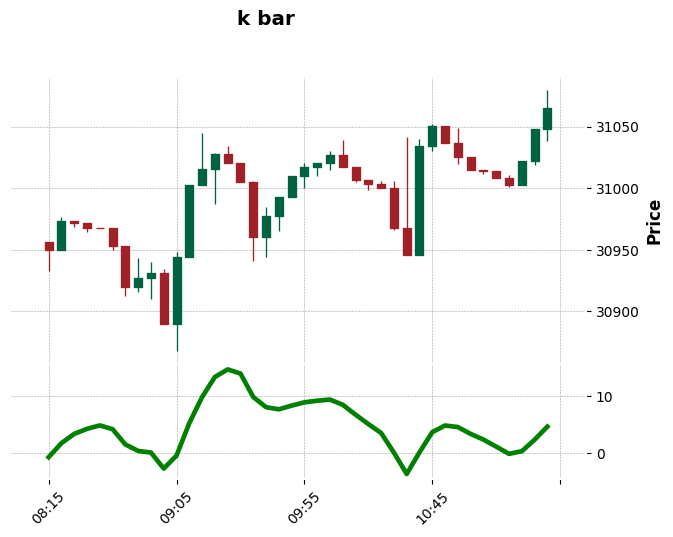

In [42]:
# 空單
while True:

  df = get_random_count_values_dataframe(dataframe[615796:])
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_short_wrapper(data)


  if isfind:
    if df['is_high_increase'].values.tolist()[-1]:
      print(df)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break